# RSJ model: CPR of $I(\phi)=[\sin(\phi)+\eta\sin(2\phi)]+A(\sin(\phi+C)+\eta\sin[2(\phi+C)])$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from scipy.integrate import odeint
from scipy.optimize import fmin
from scipy.io import savemat

In [2]:
import matplotlib as mpl
plt.rcParams.update({
    "text.usetex": True,
    "text.latex.preamble": r'\usepackage[utf8]{inputenc}',
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

In [3]:
%matplotlib inline

In [4]:
%load_ext Cython

In [5]:
h=6.626e-34
hbar=h/2/np.pi
Qe=1.608e-19

In [6]:
%%cython
cimport numpy as np
from libc.math cimport sin, cos, atanh,pi
import numpy as np

h=6.626e-34
hbar=h/2/pi
Qe=1.608e-19
Ic=2e-6
Rn=13
cpdef double CPR(double G, double A, double eta, double C):
    '''
        Current-phase relationship for the junction
    '''
    return sin(G)+eta*sin(2*G)+A*sin(G+C)+A*eta*sin(2*G+2*C)
    
cpdef double dGdt(G,double t,double I,double A, double eta,double C):
    '''
        Define y = [gamma]
        dy_dt =  - f(gamma) + i(t)) 
    '''
    der = 2*Qe*Rn*(I-Ic*CPR(G,A,eta,C))/hbar
    return der 


### Plot CPR

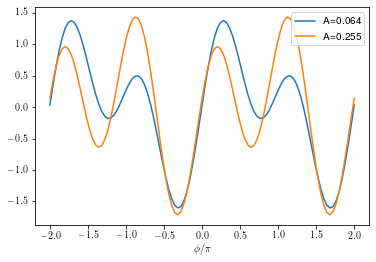

In [51]:
eta=0.8
A=np.array([0.2,0.8])
def CPR2(G, A, eta, C):
    return np.sin(G)+eta*np.sin(2*G)+A*np.sin(G+C)+A*eta*np.sin(2*G+2*C)
phi=np.linspace(-2,2,101)*np.pi

beta=np.pi*(-0.8)#np.linspace(-0.8,0.8,3)

Is=np.empty([len(phi),len(A)])
plt.figure()
for j in range(0,len(A)):
    for i in range(0,len(phi)):
        Is[i,j]=CPR2(phi[i],A[j],eta,beta)
    plt.plot(phi/np.pi,Is[:,j],label="A="+str(np.round(A[j]/np.pi,3)))
plt.xlabel('$\phi/\pi$')
plt.legend(loc=1)


## Load Data and Plot

In [7]:
import sys
#sys.path.insert(0, 'C:/Users/QMDla/Documents/GitHub/data_file_manipulations/')
sys.path.insert(0, '/Volumes/GoogleDrive/My Drive/GitHub/data_file_manipulations/')
import files_manipulation

In [8]:
import importlib

In [65]:
importlib.reload(files_manipulation)

<module 'files_manipulation' from '/Volumes/GoogleDrive/My Drive/GitHub/data_file_manipulations/files_manipulation.py'>

In [66]:
dataDir = "./"
files_manipulation.merge_multiple_mat(dataDir,True) # True for saving .h5


IDC.shape=(800,)
C.shape=(41,)
V.shape=(41, 800, 16)
DVDI.shape=(41, 800, 16)
eta.shape=(16,)
A.shape=(16,)
noise_std.shape=(16,)


### Load hdf5

In [11]:
import h5py

In [82]:
#for file in os.listdir( h5Dir ):
fd= h5py.File('merged.h5','a')
#fd.close()

In [83]:
list(fd.keys())

['A',
 'C',
 'DVDI',
 'IDC',
 'Icn',
 'Icp',
 'V',
 'eta',
 'noise_std',
 'peak_n',
 'peak_p']

In [68]:
A=fd['A'][...]
print(A.shape)
C=fd['C'][...]
print(C.shape)
DVDI=fd['DVDI'][...]
print(DVDI.shape)
IDC=fd['IDC'][...]
print(IDC.shape)
V=fd['V'][...]
print(V.shape)
eta=fd['eta'][...]
print(eta.shape)
noise_std=fd['noise_std'][...]
print(noise_std[0])

(16,)
(41,)
(41, 800, 16)
(800,)
(41, 800, 16)
(16,)
0.009


In [15]:
print(A)
print(eta)

[0.2 0.2 0.2 0.2 0.4 0.4 0.4 0.4 0.6 0.6 0.6 0.6 0.8 0.8 0.8 0.8]
[0.2 0.4 0.6 0.8 0.2 0.4 0.6 0.8 0.2 0.4 0.6 0.8 0.2 0.4 0.6 0.8]


### Plot all the $R(I_{DC}, C)$ maps

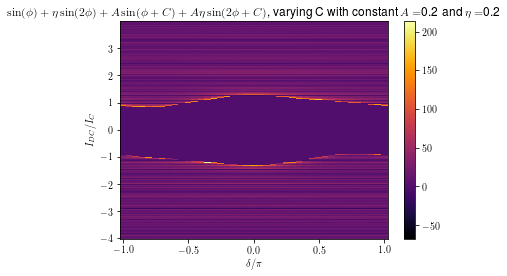

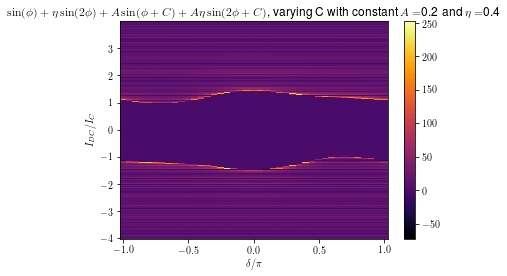

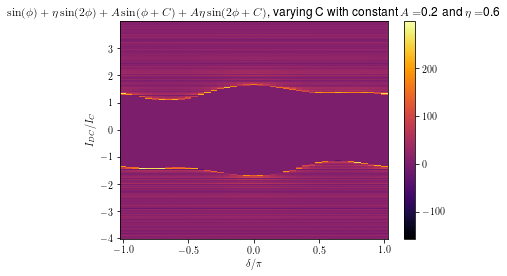

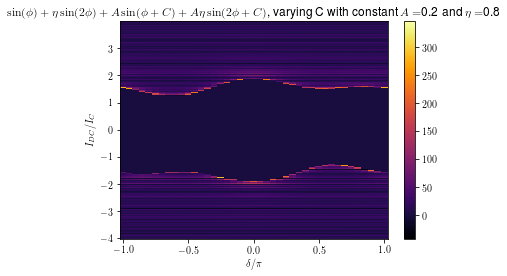

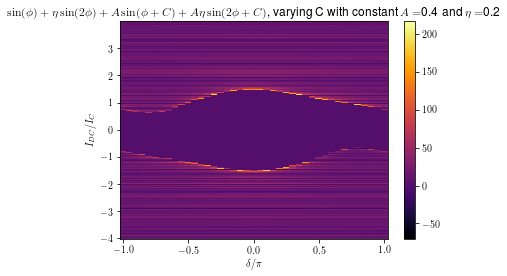

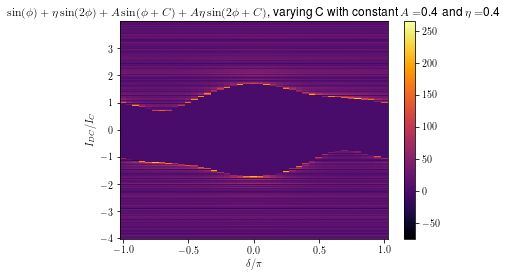

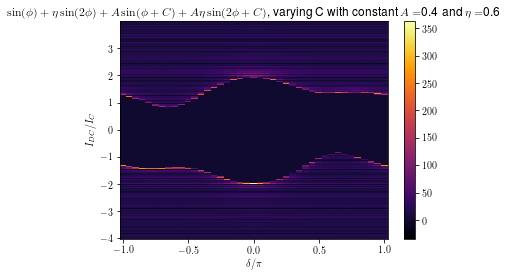

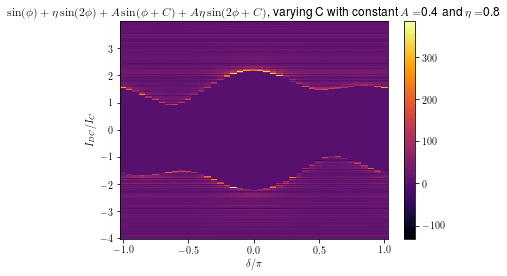

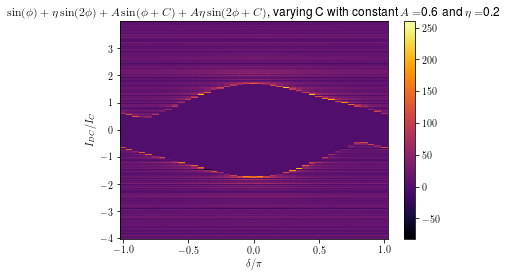

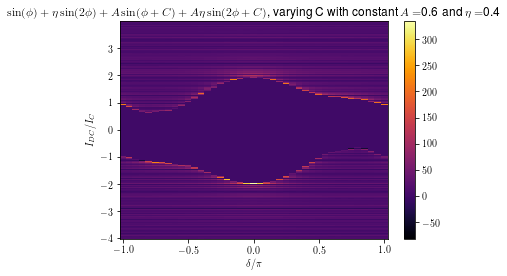

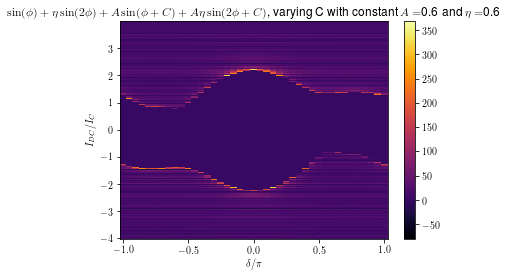

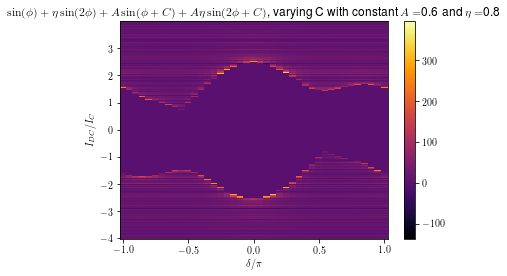

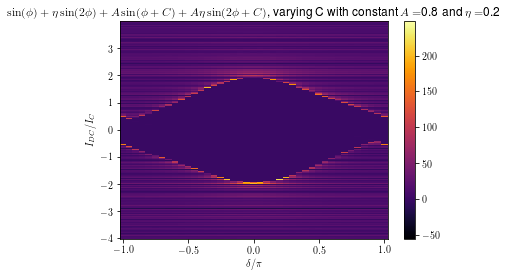

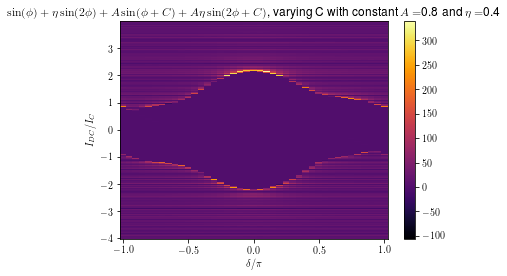

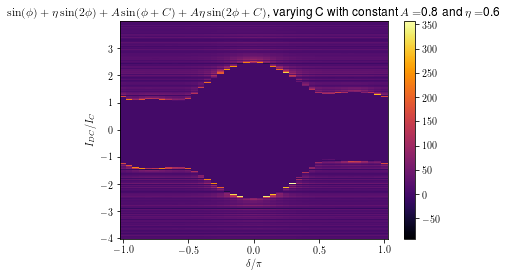

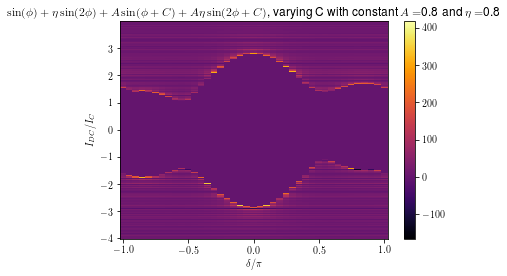

In [16]:
plt.figure()
for i in range(0,len(eta)):
    plt.pcolor(C/np.pi,IDC/Ic,np.squeeze(np.transpose(DVDI[:,:,i])),cmap='inferno',linewidth=0,rasterized=True,shading='auto')
    plt.xlabel("$\delta/\pi$")
    plt.ylabel("$I_{DC}/I_C$")
    plt.colorbar()

    plt.title("$\sin(\phi)+\eta\sin(2\phi)+A\sin(\phi+C)+A\eta\sin(2\phi+C)$, varying C with constant $A=$"+str(A[i])+" and $\eta=$"+str(eta[i]))
    plt.show()
#plt.savefig("./eta0p7_A0p5/two_channels_A0p5_eta_0p7_step_0p005_41ptC.pdf")


### Find $I_{C+}$, $I_{C-}$, asymmetry, and peak heights

In [69]:
import sys
sys.path.insert(0, '/Volumes/GoogleDrive/My Drive/GitHub/Josephson-junction-simulations/')

import extract_Ic_and_peak

In [70]:
import importlib

In [71]:
importlib.reload(extract_Ic_and_peak)

<module 'extract_Ic_and_peak' from '/Volumes/GoogleDrive/My Drive/GitHub/Josephson-junction-simulations/extract_Ic_and_peak.py'>

### Find $I_{C+}$ and $I_{C-}$ 

In [72]:
Icn=np.empty([len(C),len(eta)])
Icp=np.empty([len(C),len(eta)])
asymmetry=np.empty([len(C),len(eta)])

for j in range(0,len(eta)):
    for i in range(0,len(C)):
        #Icn[i,j],Icp[i,j],peak_n[i,j],peak_p[i,j]=
        distance_guess=len(np.squeeze(DVDI[i,:,j]))//30
        height_guess=float(DVDI[i,0,j])
        Icn[i,j],Icp[i,j]=extract_Ic_and_peak.extract_Ic(IDC,np.squeeze(DVDI[i,:,j]),distance_guess,height_guess)
        if(Icn[i,j]==0):
            print(C[i]/np.pi,eta[j],Icn[i,j],Icp[i,j])
            plt.figure()
            plt.plot(IDC,DVDI[i,:,j])
            plt.show()
            asymmetry[i,j]=1
        else:
            asymmetry[i,j]=Icp[i,j]/Icn[i,j]

### Find peak heights

In [73]:
peak_n=np.empty([len(C),len(eta)])
peak_p=np.empty([len(C),len(eta)])
for j in range(0,len(eta)):
    for i in range(0,len(C)):
        #Icn[i,j],Icp[i,j],peak_n[i,j],peak_p[i,j]=
        distance_guess=len(np.squeeze(DVDI[i,:,j]))//20
        height_guess=float(DVDI[i,0,j])*3
        peak_n[i,j],peak_p[i,j]=extract_Ic_and_peak.extract_height(IDC,np.squeeze(DVDI[i,:,j]),distance_guess,height_guess)
        if(peak_n[i,j]==0):
            print(C[i]/np.pi,eta[j],peak_n[i,j],peak_p[i,j])
            plt.figure()
            plt.plot(DVDI[i,:,j])
            plt.show()

### Append Ic's and peak heights to the .h5

In [84]:
with h5py.File('merged.h5', 'a') as f:
    dset = f.create_dataset("Icn", data=Icn)
    dset = f.create_dataset("Icp", data=Icp)
    dset = f.create_dataset("peak_n", data=peak_n)
    dset = f.create_dataset("peak_p", data=peak_p)

OSError: Unable to create link (name already exists)

In [79]:
fd.close()

In [75]:
list(f.keys())

TypeError: Not a location id (invalid object ID)

In [59]:
help(h5py.File)

Help on class File in module h5py._hl.files:

class File(h5py._hl.group.Group)
 |  File(name, mode=None, driver=None, libver=None, userblock_size=None, swmr=False, rdcc_nslots=None, rdcc_nbytes=None, rdcc_w0=None, track_order=None, **kwds)
 |  
 |  Represents an HDF5 file.
 |  
 |  Method resolution order:
 |      File
 |      h5py._hl.group.Group
 |      h5py._hl.base.HLObject
 |      h5py._hl.base.CommonStateObject
 |      h5py._hl.base.MutableMappingHDF5
 |      h5py._hl.base.MappingHDF5
 |      collections.abc.MutableMapping
 |      collections.abc.Mapping
 |      collections.abc.Collection
 |      collections.abc.Sized
 |      collections.abc.Iterable
 |      collections.abc.Container
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __enter__(self)
 |  
 |  __exit__(self, *args)
 |  
 |  __init__(self, name, mode=None, driver=None, libver=None, userblock_size=None, swmr=False, rdcc_nslots=None, rdcc_nbytes=None, rdcc_w0=None, track_order=None, **kwds)
 |      Create

In [48]:
help(fd.create_dataset)
fd.create_dataset(name="Icn",data=Icn)

Help on method create_dataset in module h5py._hl.group:

create_dataset(name, shape=None, dtype=None, data=None, **kwds) method of h5py._hl.files.File instance
    Create a new HDF5 dataset
    
    name
        Name of the dataset (absolute or relative).  Provide None to make
        an anonymous dataset.
    shape
        Dataset shape.  Use "()" for scalar datasets.  Required if "data"
        isn't provided.
    dtype
        Numpy dtype or string.  If omitted, dtype('f') will be used.
        Required if "data" isn't provided; otherwise, overrides data
        array's dtype.
    data
        Provide data to initialize the dataset.  If used, you can omit
        shape and dtype arguments.
    
    Keyword-only arguments:
    
    chunks
        (Tuple) Chunk shape, or True to enable auto-chunking.
    maxshape
        (Tuple) Make the dataset resizable up to this shape.  Use None for
        axes you want to be unlimited.
    compression
        (String or int) Compression strategy

### Plot peak heights vs C, grouped by the same A

In [25]:
colors = plt.cm.gnuplot(np.linspace(0,1,5))

In [26]:
size_A=4

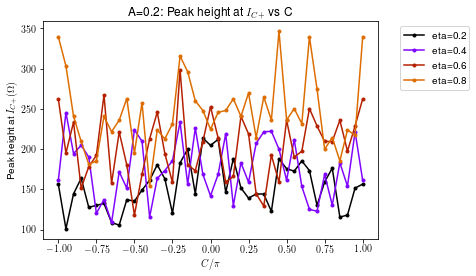

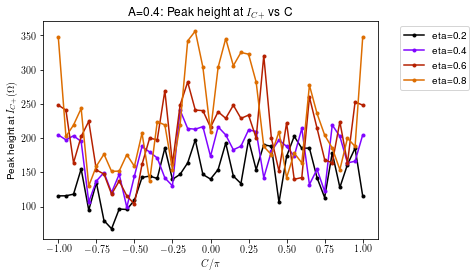

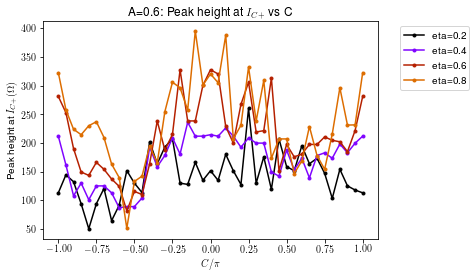

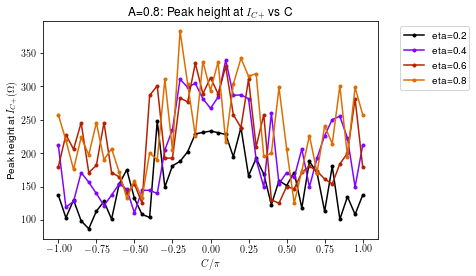

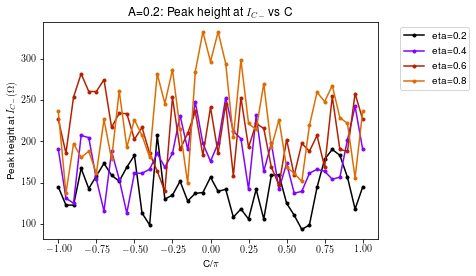

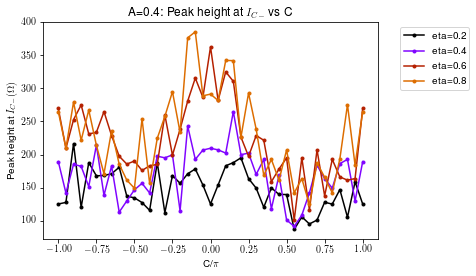

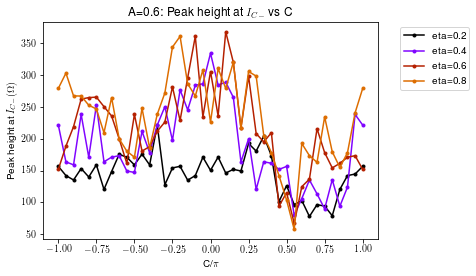

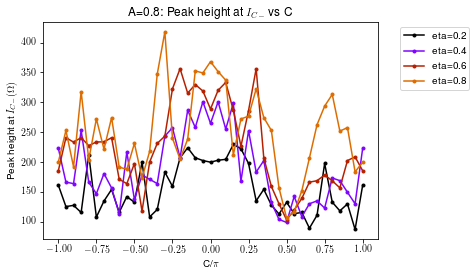

In [27]:
for j in range(0,size_A):
    plt.figure()
    cindx=0
    for i in range(0+j*size_A,(j+1)*size_A): 
        plt.plot(C/np.pi,peak_p[:,i],'.-',label='eta='+str(eta[i]),color=colors[cindx])
        cindx=cindx+1

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('A='+str(A[0+j*size_A])+': Peak height at $I_{C+}$ vs C')
    plt.xlabel('$C/\pi$')
    plt.ylabel('Peak height at $I_{C+}(\Omega)$')
    plt.show()

for j in range(0,size_A):
    plt.figure()
    cindx=0
    for i in range(0+j*size_A,(j+1)*size_A): 
        plt.plot(C/np.pi,peak_n[:,i],'.-',label='eta='+str(eta[i]),color=colors[cindx])
        cindx=cindx+1

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('A='+str(A[0+j*size_A])+': Peak height at $I_{C-}$ vs C')
    plt.xlabel('C/$\pi$')
    plt.ylabel('Peak height at $I_{C-}(\Omega)$')
    plt.show()

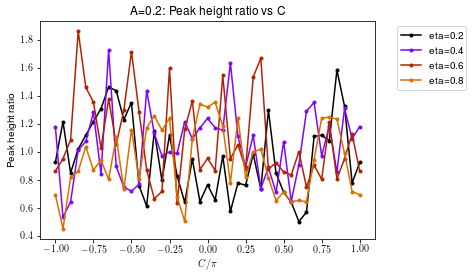

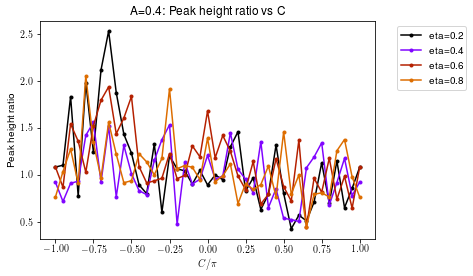

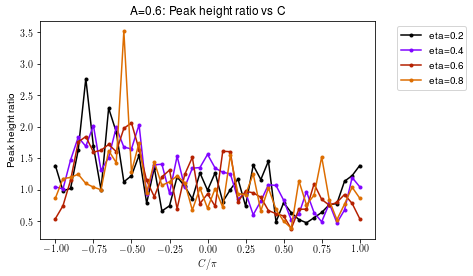

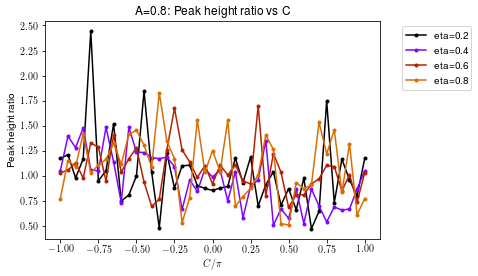

In [28]:
for j in range(0,size_A):
    plt.figure()
    cindx=0
    for i in range(0+j*size_A,(j+1)*size_A): 
        plt.plot(C/np.pi,peak_n[:,i]/peak_p[:,i],'.-',label='eta='+str(eta[i]),color=colors[cindx])
        cindx=cindx+1

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('A='+str(A[0+j*size_A])+': Peak height ratio vs C')
    plt.xlabel('$C/\pi$')
    plt.ylabel('Peak height ratio')
    plt.show()

### Load experimental data

In [45]:
exp_data=loadmat("dense_sweeps_27mK_0mT.mat")

In [46]:
list(exp_data.keys())

['__header__',
 '__version__',
 '__globals__',
 'dense27mK0mTnp',
 'dense27mK0mTpn']

In [47]:
Sweep_np=exp_data['dense27mK0mTnp'][...]
print(Sweep_np.shape)
Sweep_pn=exp_data['dense27mK0mTpn'][...]
print(Sweep_pn.shape)

(2001, 2)
(2001, 2)


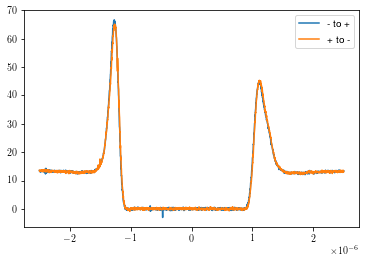

In [48]:
plt.figure()
plt.plot(Sweep_np[:,0],Sweep_np[:,1],label="- to +")
plt.plot(Sweep_pn[:,0],Sweep_pn[:,1],label="+ to -")
plt.legend()
plt.show()

In [49]:
from scipy.signal import find_peaks

In [53]:
Index,Height =find_peaks(Sweep_np[:,1],distance=600,height=2)
print(Index)
print(Height)
Index,Height =find_peaks(Sweep_pn[:,1],distance=600,height=2)
print(Index)
print(Height)

[ 492 1449]
{'peak_heights': array([66.6718804, 44.9880164])}
[ 554 1506]
{'peak_heights': array([45.327406, 65.164264])}


In [40]:
peak_n_exp=66
peak_p_exp=45
peak_ratio_exp=peak_n_exp/peak_p_exp
print(peak_ratio_exp)

1.4666666666666666


### Plot peak heights vs C, grouped by the same eta

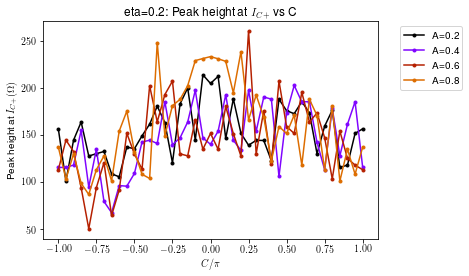

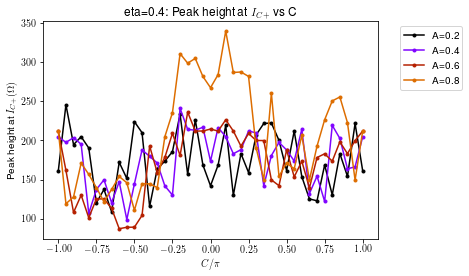

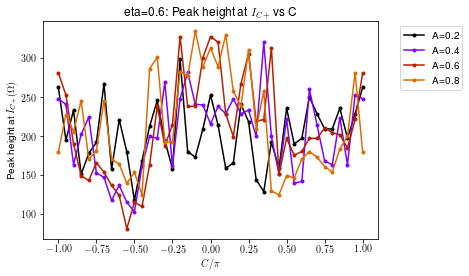

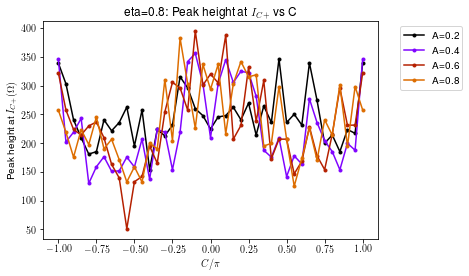

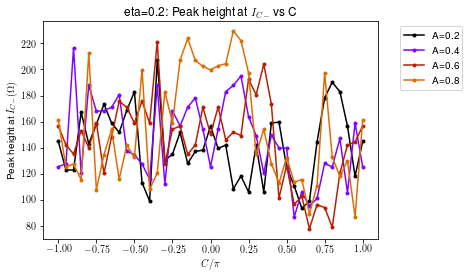

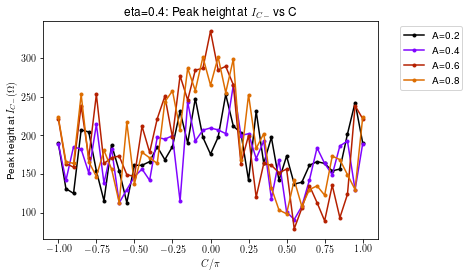

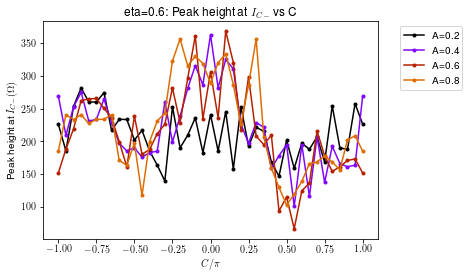

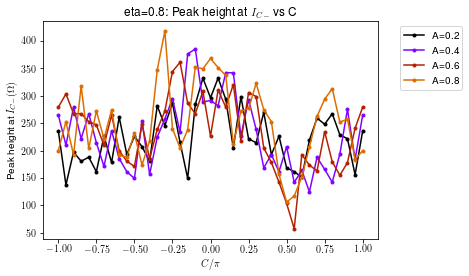

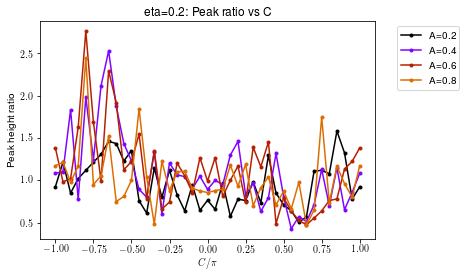

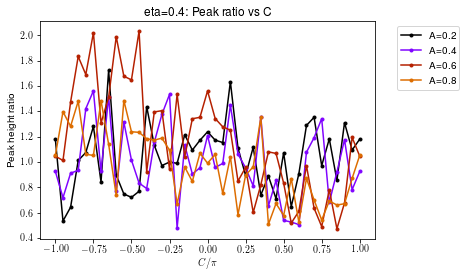

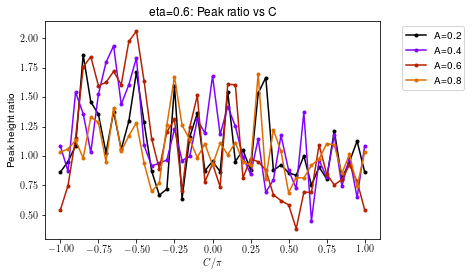

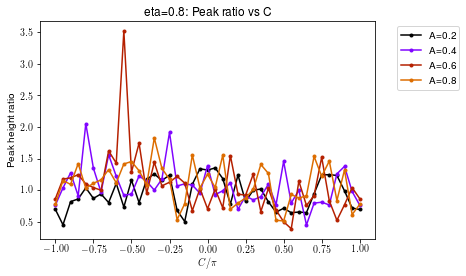

In [29]:
for j in range(0,size_A):
    plt.figure()
    cindx=0
    for i in range(j,len(eta),size_A):
        plt.plot(C/np.pi,peak_p[:,i],'.-',label='A='+str(A[i]),color=colors[cindx])
        cindx=cindx+1

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('eta='+str(eta[j])+': Peak height at $I_{C+}$ vs C')
    plt.xlabel('$C/\pi$')
    plt.ylabel('Peak height at $I_{C+}(\Omega)$')
    plt.show()

for j in range(0,size_A):
    plt.figure()
    cindx=0
    for i in range(j,len(eta),size_A):
        plt.plot(C/np.pi,peak_n[:,i],'.-',label='A='+str(A[i]),color=colors[cindx])
        cindx=cindx+1

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('eta='+str(eta[j])+': Peak height at $I_{C-}$ vs C')
    plt.xlabel('$C/\pi$')
    plt.ylabel('Peak height at $I_{C-}(\Omega)$')
    plt.show()

for j in range(0,size_A):
    plt.figure()
    cindx=0
    for i in range(j,len(eta),size_A):
        plt.plot(C/np.pi,peak_n[:,i]/peak_p[:,i],'.-',label='A='+str(A[i]),color=colors[cindx])
        cindx=cindx+1

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('eta='+str(eta[j])+': Peak ratio vs C')
    plt.xlabel('$C/\pi$')
    plt.ylabel('Peak height ratio')
    plt.show()

### Asymmetry

In [30]:
asymm_exp=np.ones(len(C))*0.83

### Asymmetry vs C, grouped by the same A

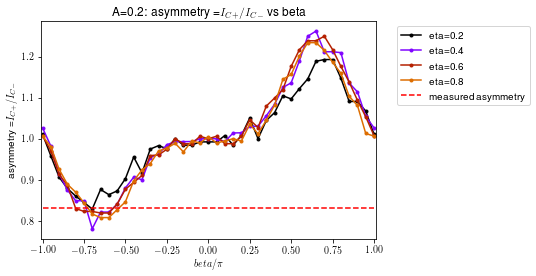

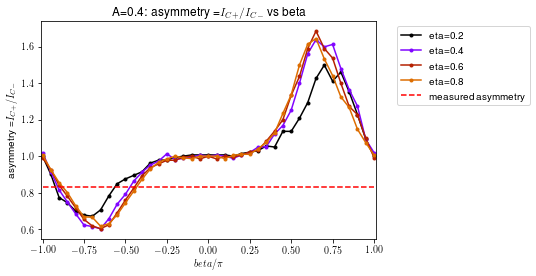

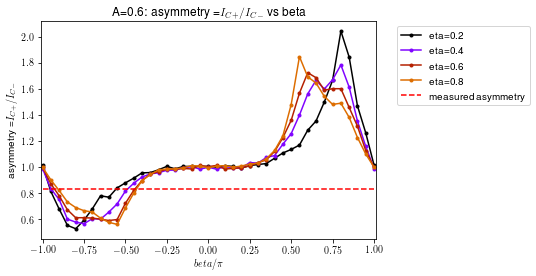

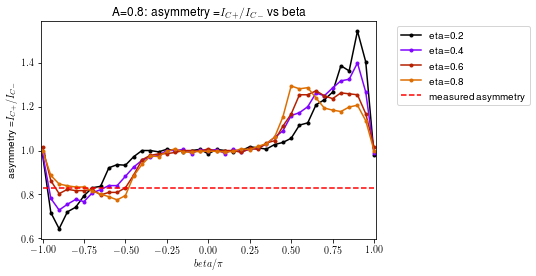

In [31]:
for j in range(0,size_A):
    plt.figure()
    cindx=0
    for i in range(0+j*size_A,(j+1)*size_A): 
        plt.plot(C/np.pi,asymmetry[:,i],'.-',label='eta='+str(eta[i]),color=colors[cindx])
        cindx=cindx+1
    plt.plot(C/np.pi,asymm_exp,'r--',label="measured asymmetry")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("A="+str(A[0+j*size_A])+": asymmetry =$I_{C+}/I_{C-}$ vs beta")
    plt.xlim([-1.01,1.01])
    plt.xlabel("$beta/\pi$")
    plt.ylabel('asymmetry =$I_{C+}/I_{C-}$')
    plt.show()

### Asymmetry vs C, grouped by the same eta

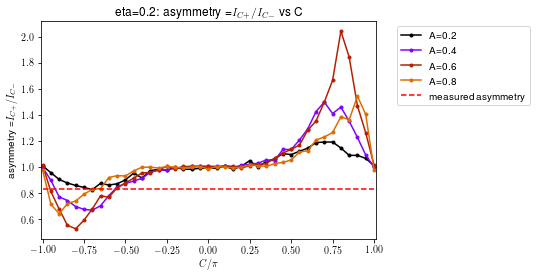

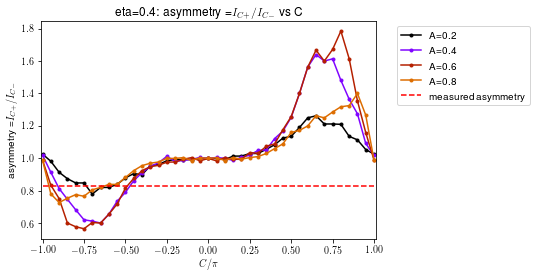

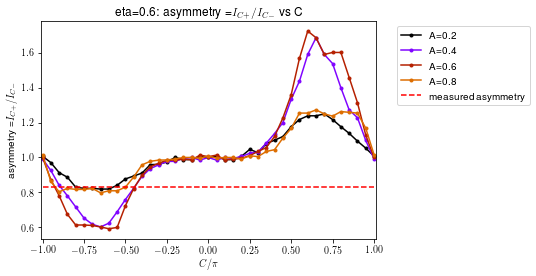

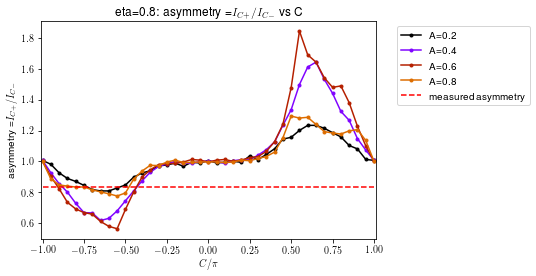

In [32]:
for j in range(0,size_A):
    plt.figure()
    cindx=0
    for i in range(j,len(eta),size_A):
        plt.plot(C/np.pi,asymmetry[:,i],'.-',label='A='+str(A[i]),color=colors[cindx])
        cindx=cindx+1
    plt.plot(C/np.pi,asymm_exp,'r--',label="measured asymmetry")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('eta='+str(eta[j])+': asymmetry =$I_{C+}/I_{C-}$ vs C')
    plt.xlim([-1.01,1.01])
    plt.xlabel('$C/\pi$')
    plt.ylabel('asymmetry =$I_{C+}/I_{C-}$')
    plt.show()

### $I_{C+}$ vs C, grouped by the same A

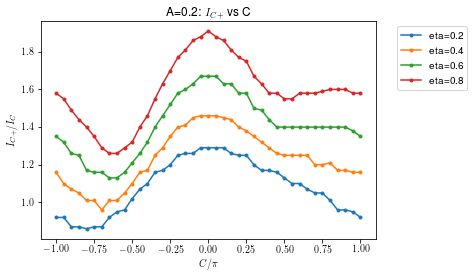

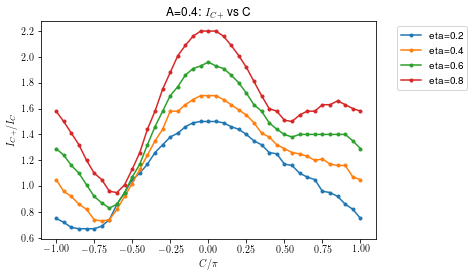

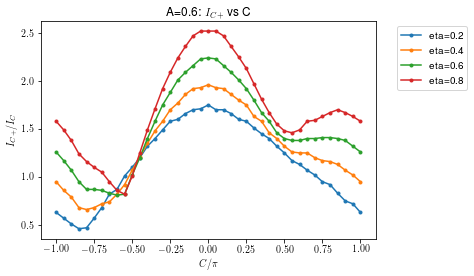

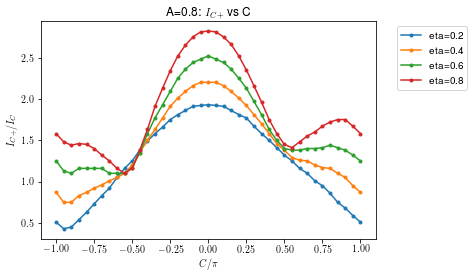

In [33]:
for j in range(0,size_A):
    plt.figure()
    for i in range(0+j*size_A,(j+1)*size_A): 
        plt.plot(C/np.pi,Icp[:,i]/Ic,'.-',label='eta='+str(eta[i]))
    plt.title('A='+str(A[0+j*size_A])+': $I_{C+}$ vs C')
    plt.xlabel('$C/\pi$')
    plt.ylabel('$I_{C+}/I_C$')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

### $I_{C-}$ vs C, grouped by the same A


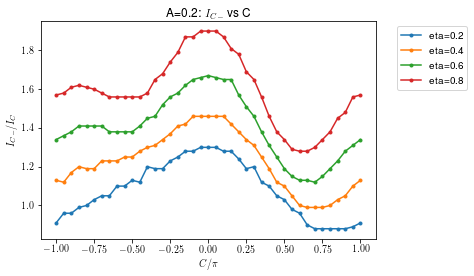

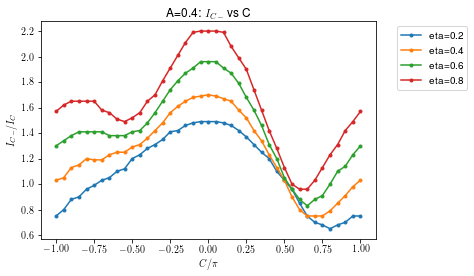

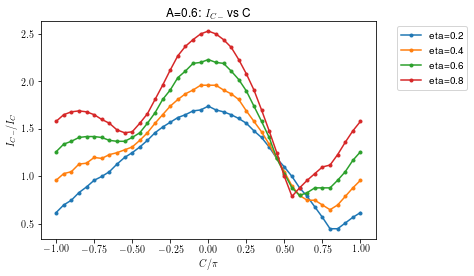

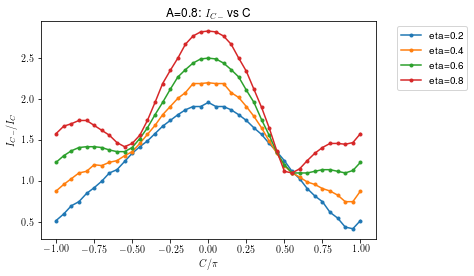

In [34]:
for j in range(0,size_A):
    plt.figure()
    for i in range(0+j*size_A,(j+1)*size_A): 
        plt.plot(C/np.pi,Icn[:,i]/Ic,'.-',label='eta='+str(eta[i]))
    plt.title('A='+str(A[0+j*size_A])+': $I_{C-}$ vs C')
    plt.xlabel('$C/\pi$')
    plt.ylabel('$I_{C-}/I_C$')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Save it into a .csv file

In [74]:
np.savetxt("./eta0p7_A0p5/csv/IDC.csv", IDC, delimiter=",")
np.savetxt("./eta0p7_A0p5/csv/C.csv", C, delimiter=",")
np.savetxt("./eta0p7_A0p5/csv/V.csv", V, delimiter=",")
np.savetxt("./eta0p7_A0p5/csv/DVDI.csv", DVDI, delimiter=",")
